<a href="https://colab.research.google.com/github/sergioanez/FIV-Harvesting/blob/main/FIV_force_prediction_LSTM_10sensors_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIV force prediction neural network with 10 evenly spaced sensors on the channel walls (5x2)

input: features, labels
 - features = flow field at specific points (sensors) 
 - labels = known forces (lift and drag)

output: predicted forces (lift and drag)

----



In [170]:
# sensor locations:

# 5x2 grid 
x_sensors = 5
y_sensors = 2
num_sensors = x_sensors * y_sensors


# all uStars being imported
uStars = ["uStar3_75", "uStar7_50"]
# specific uStar
uStar_num = 7.50

# Neural network parameters
epochs = 100
neurons_per_layer = 128
train_window = 60
prediction_window = 60
num_labels = 1 #lift
hidden_size_ratio = 0.5
batch_size = 60
lr = 0.001 # learning rate


### Importing reduced data
we pre selected data at 10 sensor locations (on walls) in MATLAB


In [ ]:
%pip install mat73

In [ ]:
import scipy.io as spio
import mat73

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Colab\ Notebooks/FIV\ force\ prediction/reduced_files_5_2

Archive:  gdrive/My Drive/Colab Notebooks/FIV force prediction/reduced_files_5_2.zip
  inflating: uStar3_75/configuration.mat  
  inflating: uStar3_75/positionVelocity.mat  
  inflating: uStar3_75/reducedField_5_2.mat  
  inflating: uStar7_50/configuration.mat  
  inflating: uStar7_50/positionVelocity.mat  
  inflating: uStar7_50/reducedField_5_2.mat  


### putting data in dataframe

In [ ]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import IPython
import IPython.display
from scipy import interpolate
from scipy.interpolate import interp1d

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
dataset = pd.DataFrame()

for uStar in uStars:

  # organize data
  posVel = mat73.loadmat(uStar + '/positionVelocity.mat')
  reducedField_5_6 = spio.loadmat(uStar + '/reducedField_5_2.mat', squeeze_me=True)
  reducedField_5_6 = reducedField_5_6['reducedField']
  config = spio.loadmat(uStar + '/configuration.mat', squeeze_me=True)

  xIndices = np.linspace(0,config['numX']-1,x_sensors).astype(int)
  yIndices = np.linspace(0,config['numY']-1,y_sensors).astype(int) 
  x = config["X"][0,xIndices]
  y = config["Y"][yIndices,0]

  numT = config['numT']
  time_steps = np.arange(numT)

  # add x, y, time steps
  a = [y,x,time_steps]
  data = list(itertools.product(*a))
  df = pd.DataFrame(data=data, columns=["y", "x", "t"])

  # add u and v
  df['u'] = reducedField_5_6[:,:,:,0].flatten()
  df['v'] = reducedField_5_6[:,:,:,1].flatten()

  # add cylinder properties (lift, drag, pos, vel)
  df['lift'] = np.tile(posVel['lift'], x_sensors*y_sensors)
  df['drag'] = np.tile(posVel['drag'], x_sensors*y_sensors)
  df['pos'] = np.tile(posVel['position'], x_sensors*y_sensors)
  df['vel'] = np.tile(posVel['velocity'], x_sensors*y_sensors)

  # add uStar
  uStar_float = uStar[5:]
  uStar_float = uStar_float.replace('_', '.')
  uStar_float = float(uStar_float)
  df['uStar'] = uStar_float

  dataset = dataset.append(df)
  
dataset.reset_index(inplace=True, drop=True)


In [ ]:
dataset

,y,x,t,u,v,lift,drag,pos,vel,uStar
0,51.443524,-14.110060,0,0.221441,0.004109,0.040710,-0.224721,0.000386,-0.021276,3.75
1,51.443524,-14.110060,1,0.221361,0.001884,-0.074137,-0.290276,-0.000382,-0.015700,3.75
2,51.443524,-14.110060,2,0.220746,0.004701,-0.285623,-0.255234,-0.000912,-0.010408,3.75
3,51.443524,-14.110060,3,0.223347,0.004990,-0.243094,-0.286218,-0.001194,-0.000195,3.75
4,51.443524,-14.110060,4,0.224962,0.008288,-0.244433,-0.279614,-0.000909,0.011848,3.75
...,...,...,...,...,...,...,...,...,...,...
95335,-71.263671,120.517263,4762,0.212527,0.001701,0.122661,-0.269683,0.006162,-0.057718,7.50
95336,-71.263671,120.517263,4763,0.216399,0.001463,0.083157,-0.364361,0.003224,-0.081416,7.50
95337,-71.263671,120.517263,4764,0.220276,0.002502,-0.011242,-0.269193,-0.000412,-0.095636,7.50
95338,-71.263671,120.517263,4765,0.231104,0.004516,-0.141422,-0.323835,-0.003997,-0.085431,7.50


### Looking at specific uStar

In [ ]:
dataset_uStar = dataset[dataset['uStar'] == uStar_num]
dataset_uStar = dataset_uStar.sort_values(by=['t'])
dataset_uStar = dataset_uStar.drop(columns=['y', 'x', 'pos', 'vel', 'uStar'])

In [ ]:
# reshaping

dataset_uStar['idx'] = dataset_uStar.groupby('t').cumcount()
dataset_uStar.pivot(index='t',columns='idx')[['u','v']]

dataset_uStar['u_idx'] = 'u_' + dataset_uStar.idx.astype(str)
dataset_uStar['v_idx'] = 'v_' + dataset_uStar.idx.astype(str)

u = dataset_uStar.pivot(index='t',columns='u_idx', values='u')
v = dataset_uStar.pivot(index='t',columns='v_idx', values='v')

dataset_uStar_wide = pd.concat([u,v],axis=1)
dataset_uStar_wide['lift'] = dataset_uStar.set_index('t')['lift'].drop_duplicates()
dataset_uStar_wide['drag'] = dataset_uStar.set_index('t')['drag'].drop_duplicates()
dataset_uStar_wide

,u_0,u_1,u_2,u_3,u_4,u_5,u_6,u_7,u_8,u_9,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,lift,drag
t,,,,,,,,,,,,,,,,,,,,,,
0,0.224310,0.237956,0.217083,0.190659,0.236601,0.228256,0.211595,0.221532,0.228306,0.213100,0.004723,0.002276,-0.001520,-0.026849,-0.004417,0.005963,0.004265,-0.008814,-0.007258,0.015377,0.040283,-0.299843
1,0.233637,0.219458,0.220386,0.218004,0.210364,0.246440,0.227861,0.221866,0.224781,0.230039,0.001651,-0.002882,0.005184,-0.008908,0.008700,0.007459,0.006677,-0.020866,-0.012194,-0.000234,0.168645,-0.229706
2,0.209263,0.236972,0.217120,0.228698,0.219631,0.231075,0.219115,0.226739,0.254393,0.207462,0.003015,-0.004984,-0.007574,0.004889,-0.004474,-0.007297,-0.012975,0.006593,0.036692,-0.006787,0.154994,-0.240834
3,0.208637,0.215370,0.213724,0.228541,0.232729,0.230781,0.211164,0.236236,0.222982,0.216687,0.047551,-0.010225,-0.004897,0.007197,-0.009601,0.008444,0.000553,-0.012626,-0.005827,0.001266,0.277487,-0.266792
4,0.211869,0.229665,0.218341,0.235628,0.224666,0.228278,0.234074,0.214927,0.201247,0.217372,-0.004208,-0.021622,0.006703,0.006097,-0.004619,0.007859,-0.013885,-0.007623,0.019766,-0.005567,0.155012,-0.245786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,0.222578,0.224002,0.211855,0.216811,0.211185,0.229000,0.225948,0.217407,0.212527,0.000000,-0.015805,-0.004980,-0.002759,-0.002876,-0.000469,0.002056,0.006977,0.013642,0.001701,0.000000,0.122661,-0.269683
4763,0.223718,0.210602,0.214061,0.216399,0.233449,0.225177,0.216903,0.232949,0.212239,0.213953,-0.005284,-0.000387,-0.016698,0.001463,0.007541,0.008476,-0.003798,-0.002048,-0.003899,0.008268,0.083157,-0.364361
4764,0.207712,0.209519,0.223408,0.220276,0.214200,0.214175,0.224686,0.232957,0.221550,0.234467,0.007307,-0.010944,0.008760,0.002502,-0.004843,0.003524,-0.002798,0.019048,-0.004367,-0.007076,-0.011242,-0.269193


In [ ]:
#rename df
df = dataset_uStar_wide.copy()

#DROP DRAG TEMPORARILY
df = df.drop(columns=['drag'])

In [ ]:
# split the data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.5)]
test_df = df[int(n*0.5):]

num_features = df.shape[1] - num_labels

In [ ]:
# normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

# convert data to Tensor

In [ ]:
train_df = np.array(train_df, dtype=np.float32)
train_df = torch.from_numpy(train_df)

# convert our training data into sequences and corresponding labels

In [117]:
def create_inout_sequences(input_data, tw, pw):
  # tw = training window
  # pw = prediction window
    inout_seq = []
    inseq = []
    outlabel = []
    L = len(input_data)
    for i in range(L-tw-pw):
        if (i % 100000 == 0):
            print(i)
        train_seq = input_data[i:i+tw][:,:-1]
        train_label = input_data[i+tw:i+tw+pw][:,-1]
        inout_seq.append((train_seq, train_label))
        inseq.append(train_seq)
        outlabel.append(train_label)
    return inout_seq, inseq, outlabel

In [118]:
train_inout_seq, train_inseq, train_outlabel = create_inout_sequences(train_df, train_window, prediction_window)

0


# Prepare data for training with DataLoader

In [119]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=False, drop_last=True)
#test_dataloader = DataLoader(test_df, batch_size=batch_size, shuffle=False)

# LSTM model

In [171]:
class extractlastcell(nn.Module):
    def forward(self,x):
        out , _ = x
        return out[-1]

In [172]:
hidden_size = int(hidden_size_ratio * num_features)

In [173]:
model = nn.Sequential(nn.LSTM(num_features, hidden_size, dropout=0.2, num_layers=2),
                      extractlastcell(),
                      nn.ReLU(),
                      nn.Linear(hidden_size, 2*hidden_size),
                      nn.ReLU(),
                      nn.Linear(2*hidden_size, prediction_window))

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [174]:
model

Sequential(
  (0): LSTM(20, 10, num_layers=2, dropout=0.2)
  (1): extractlastcell()
  (2): ReLU()
  (3): Linear(in_features=10, out_features=20, bias=True)
  (4): ReLU()
  (5): Linear(in_features=20, out_features=60, bias=True)
)

In [175]:
import copy

loss_list = []
for epoch in range(epochs):

  # training

  model.train()
  running_loss = 0.0
  for batch_idx, batch in enumerate(train_dataloader):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        #if batch_idx % 10 == 9:    # print every 2000 mini-batches
            #print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {running_loss / 10:.3f}')
            #loss_list.append(running_loss / 10)
            #running_loss = 0.0

  avg_loss = running_loss / batch_idx
  loss_list.append(avg_loss)
  print(f'epoch: {epoch:3} loss: {avg_loss:10.8f}')
        


  # validation
  #temp_model = copy.deepcopy(model)
  #temp_model.eval()
  #for i,j in enumerate(dataloader_val):


print('Finished Training') 

epoch:   0 loss: 1.03640541
epoch:   1 loss: 1.02758422
epoch:   2 loss: 1.01463962
epoch:   3 loss: 0.95300997
epoch:   4 loss: 0.80718925
epoch:   5 loss: 0.58761251
epoch:   6 loss: 0.35536181
epoch:   7 loss: 0.23530484
epoch:   8 loss: 0.18348299
epoch:   9 loss: 0.15707201
epoch:  10 loss: 0.13896630
epoch:  11 loss: 0.13011324
epoch:  12 loss: 0.12143340
epoch:  13 loss: 0.11709671
epoch:  14 loss: 0.10823235
epoch:  15 loss: 0.09909872
epoch:  16 loss: 0.09613544
epoch:  17 loss: 0.09425311
epoch:  18 loss: 0.09177002
epoch:  19 loss: 0.09470529
epoch:  20 loss: 0.09281501
epoch:  21 loss: 0.09396292
epoch:  22 loss: 0.09689186
epoch:  23 loss: 0.10161872
epoch:  24 loss: 0.11287855
epoch:  25 loss: 0.11002760
epoch:  26 loss: 0.11754539
epoch:  27 loss: 0.14507669
epoch:  28 loss: 0.19704354
epoch:  29 loss: 0.26657526
epoch:  30 loss: 0.33195301
epoch:  31 loss: 0.24968962
epoch:  32 loss: 0.15774099
epoch:  33 loss: 0.13014468
epoch:  34 loss: 0.11570693
epoch:  35 loss: 0.1

Text(0, 0.5, 'loss')

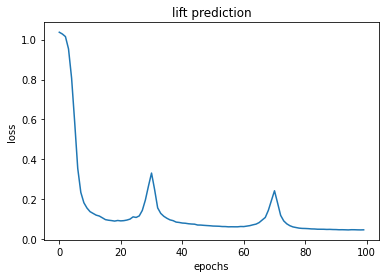

In [177]:
plt.plot(range(epochs), loss_list)
plt.title('lift prediction')
plt.xlabel('epochs')
plt.ylabel('loss')